In [2]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


In [4]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


# 1. Rate is constant for all years and not depending on anything

In [5]:
Airline_data['Passenger deaths'].mean()

691.9

## Prior predictive checks

In [43]:

with open('predict_model_1.stan', 'r') as file:
    print(file.read())

generated quantities{
  real lambda = normal_rng(692,200);
  int deaths = poisson_rng(lambda);
}



In [15]:
model1=stan_utility.compile_model('predict_model_1.stan')

Using cached StanModel


In [16]:
sim = model1.sampling(data=dict(),
                         iter=1000,
                         warmup=0,
                         refresh=1000,
                         algorithm='Fixed_param',
                         seed=10000)

In [28]:
params = sim.extract();
lambdas = params['lambda'];
deaths = params['deaths'];

C:\Users\Piotrek\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Piotrek\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


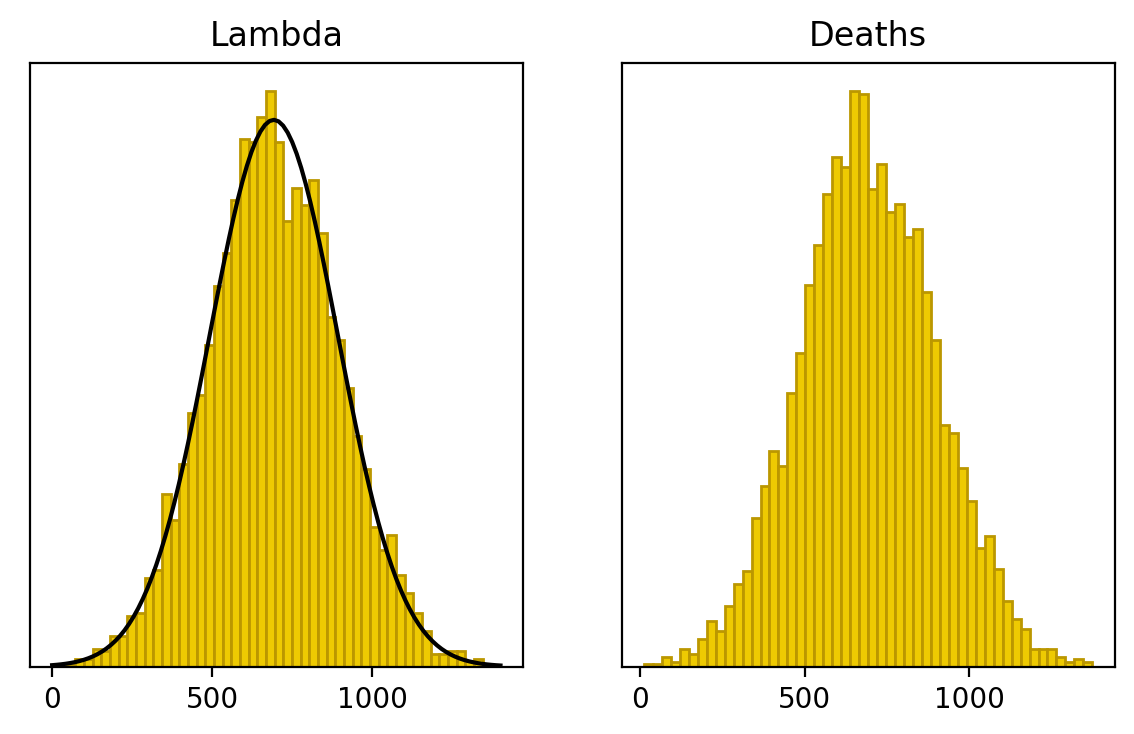

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(lambdas,bins=50,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_yticks([])
x=np.linspace(0,1400,100)
y=stats.norm.pdf(x,loc=692,scale=200)
ax1.plot(x,y,'black')
ax1.set_title('Lambda')


ax2=axes[1]
ax2.hist(deaths,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('Deaths')
ax2.set_yticks([])
plt.show()

Observing death distribution we can realize that in the next year probably about 700 people will die.

## Posterior and interference 

In [63]:
with open('predict_model_1_2.stan', 'r') as file:
    print(file.read())

data {
    int n;
    int deaths[n];
}
parameters{
    real<lower=0> lambda;
}
model {
    lambda ~ normal(692,200);
    deaths ~ poisson(lambda);
}
generated quantities {
    int y = poisson_rng(lambda);
}



In [64]:
model1_2=stan_utility.compile_model('predict_model_1_2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c763c115652d467012173ae3581bf5b5 NOW.


In [66]:
fit=model1_2.sampling(data=dict(n=len(Airline_data['Passenger deaths']),
                                   deaths=Airline_data['Passenger deaths']),
                         seed=100000)

In [67]:
az.summary(fit,var_names=['lambda'],round_to=2,kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,691.69,8.3,675.23,706.37


In [69]:
params=fit.extract()
params_lambda=params['lambda']
params_death=params['y']

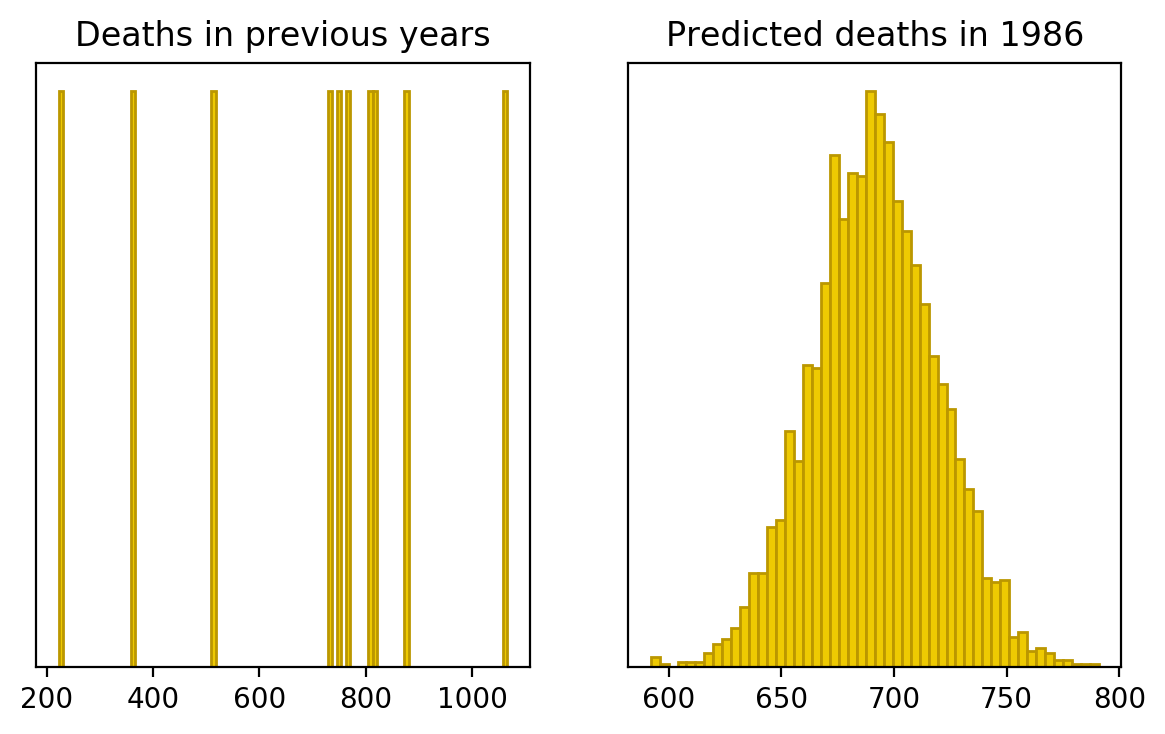

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax1=axes[0]
ax1.hist(Airline_data['Passenger deaths'],bins=100,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('Deaths in previous years')
ax1.set_yticks([])


ax2=axes[1]
ax2.hist(params_death,color=dark,edgecolor=dark_highlight,density=True,bins=50)
ax2.set_title('Predicted deaths in 1986')
ax2.set_yticks([])
plt.show()

# Summary

The model was very easy to implement, the results look intuitive. The prediction
is based on poisson distribution, depending on mean number of deaths in previous years.
I have some doubts concerning this method. For example, in case of much bigger number
of flights in 1986, more deaths would be possible. This method does not count such scenario.


# 2. The intensity is constant , but rate is a product of intensity and miles flown

In [44]:
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [129]:
with open('predict_model_2.stan', 'r') as file:
    print(file.read())

data{
  int n;
  real miles[n];
}
generated quantities{
  real beta = beta_rng(2,8); //Observing rate in previous years we can see, that it oscilates around 0.15 value
  int y[n];
  for (i in 1:n){
    y[i] = poisson_rng(miles[i]*beta);
  }
}



In [142]:
model2=stan_utility.compile_model('predict_model_2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7b30ae29793e8608358e0ac11c04db77 NOW.


In [143]:
R = 1000
data_sim=dict(n=50,miles=np.linspace(Airline_data['Miles flown [100 mln miles]'].min(),Airline_data['Miles flown [100 mln miles]'].max()))
fit2=model2.sampling(data=data_sim, iter=R, warmup=0, chains=1, refresh=R,algorithm='Fixed_param',
                     seed=100000)

In [144]:
params2 = fit2.extract()
beta2 = params2['beta']

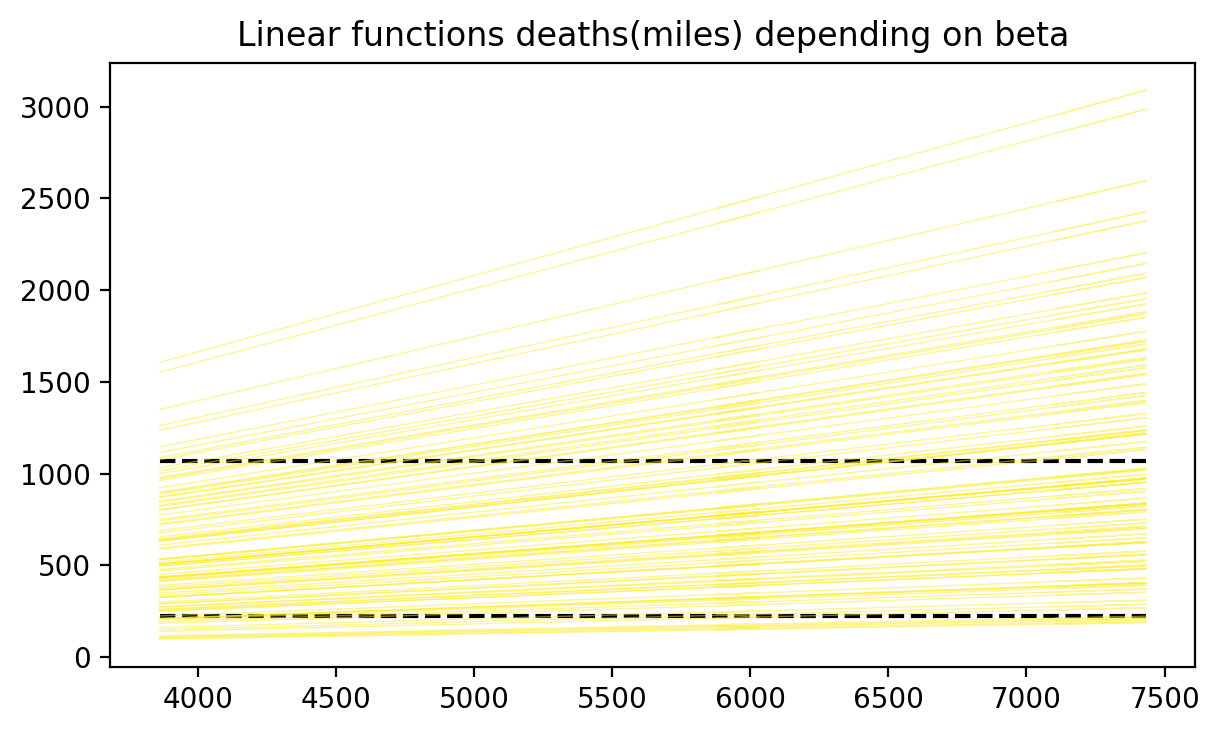

In [145]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes.hlines([Airline_data['Passenger deaths'].min(),Airline_data['Passenger deaths'].max()],xmin=Airline_data['Miles flown [100 mln miles]'].min(),xmax=Airline_data['Miles flown [100 mln miles]'].max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(Airline_data['Miles flown [100 mln miles]'],beta2[i]*Airline_data['Miles flown [100 mln miles]'],color=mid,alpha=0.5,linewidth=0.5)
axes.set_title('Linear functions deaths(miles) depending on beta')
plt.show()

In [146]:
from DA_tools import ribbon_plot, light, light_highlight, mid, mid_highlight, dark, dark_highlight

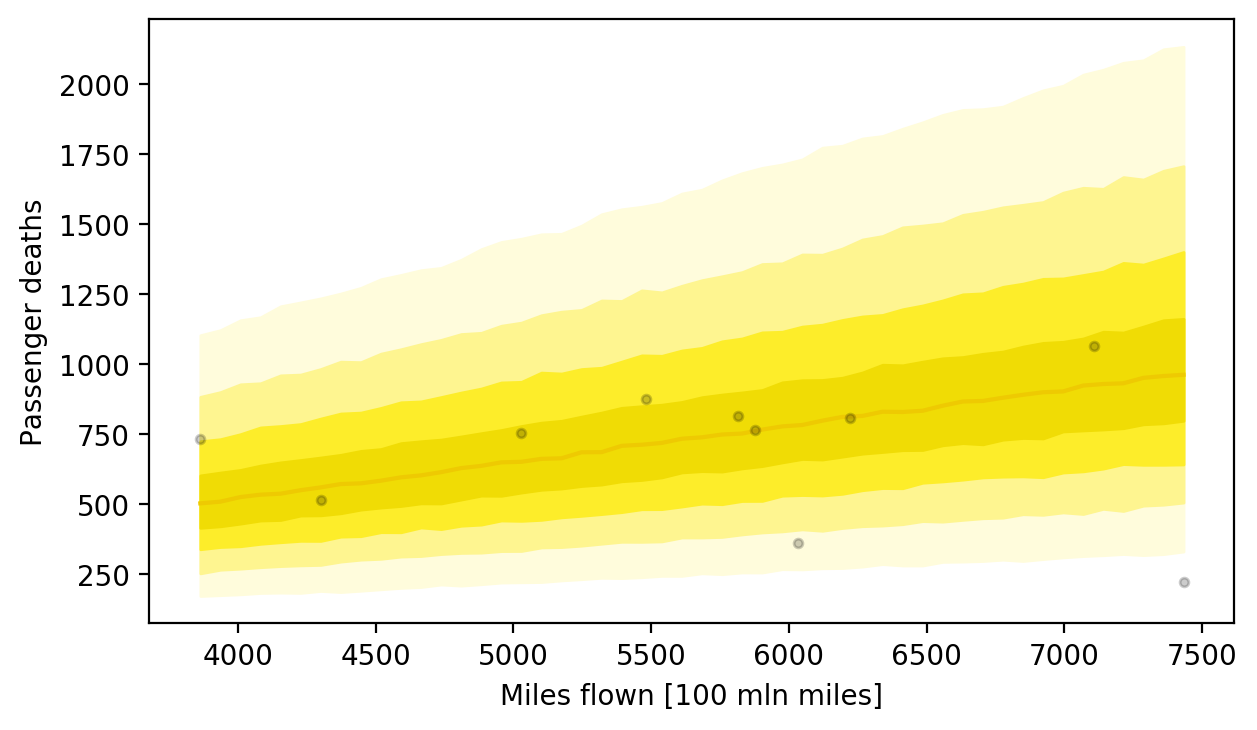

In [147]:
deaths_sim=params2['y']

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes=ribbon_plot(data_sim['miles'],deaths_sim,axes)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.2,s=10)
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_ylabel('Passenger deaths')
plt.show()

In [149]:
with open('predict_model_2_2.stan', 'r') as file:
    print(file.read())

data {
  int n;
  vector[n] miles;
  int deaths[n];
}

parameters {
  real beta;
}

transformed parameters {
  vector[N] lambda = miles*beta;
}

model {
  beta ~ beta(2,11);
  deaths ~ poisson(lambda);
}

generated quantities {
  real y[n];
  for (i in 1:n) {
    y[i] = poisson_rng(lambda[i]);
  }
}



In [151]:
model2_2=stan_utility.compile_model('predict_model_2_2.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bed754d9c31de84fb2090cacdefe8092 NOW.


In [152]:
fit3 = model2_2.sampling(data=dict(n=len(Airline_data),
              deaths=Airline_data['Passenger deaths'],
              miles=Airline_data['Miles flown [100 mln miles]']),
                                 seed=100000)

In [153]:
params3 = fit3.extract()
params3_beta=params3['beta']
params3_lambda=params3['lambda']
params3_y=params3['y']

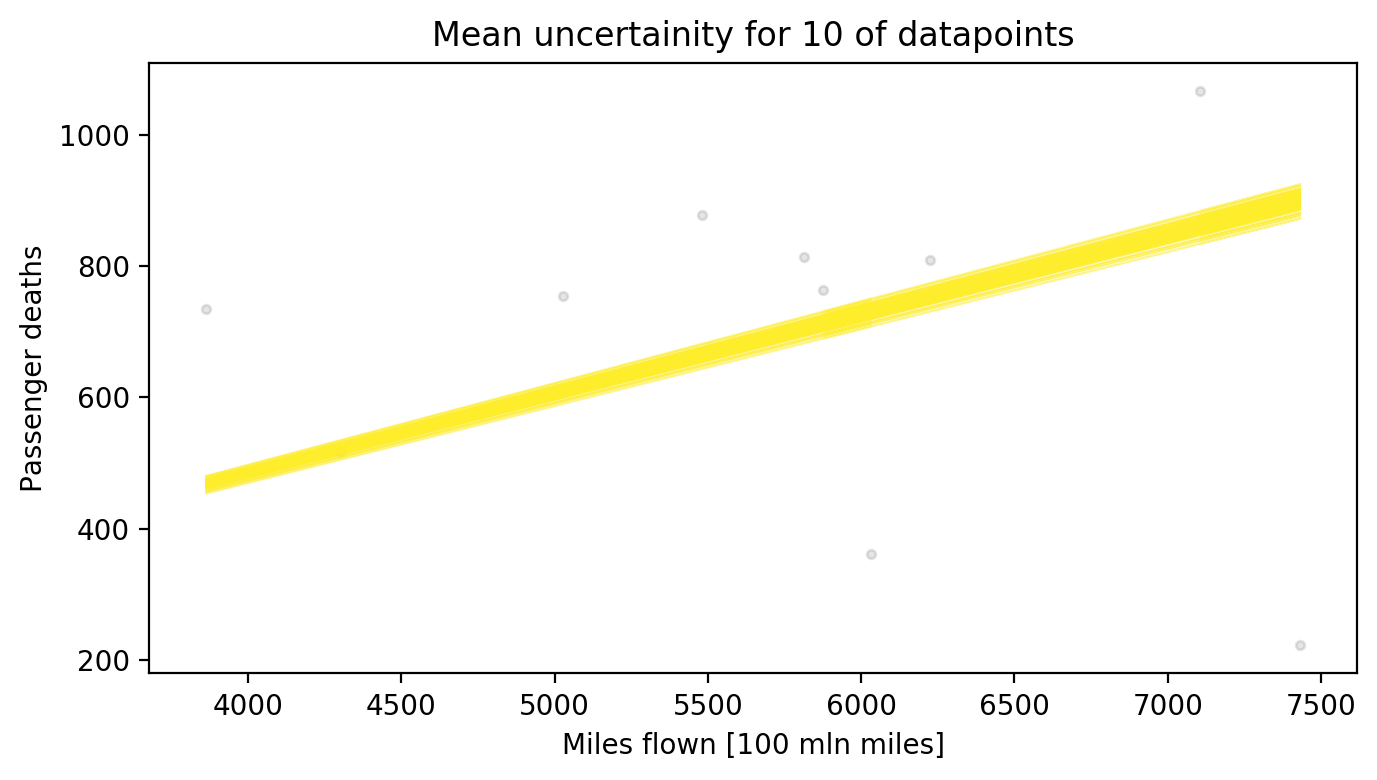

In [154]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True)
for i in range(100):
    axes.plot(Airline_data['Miles flown [100 mln miles]'],
              params3_beta[i]*Airline_data['Miles flown [100 mln miles]'],
              color=mid,
              alpha=0.5,
              linewidth=0.5)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.1,s=10)
axes.set_ylabel('Passenger deaths')
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_title('Mean uncertainity for {} of datapoints'.format(len(Airline_data)))
fig.tight_layout()
plt.show()

Sorting


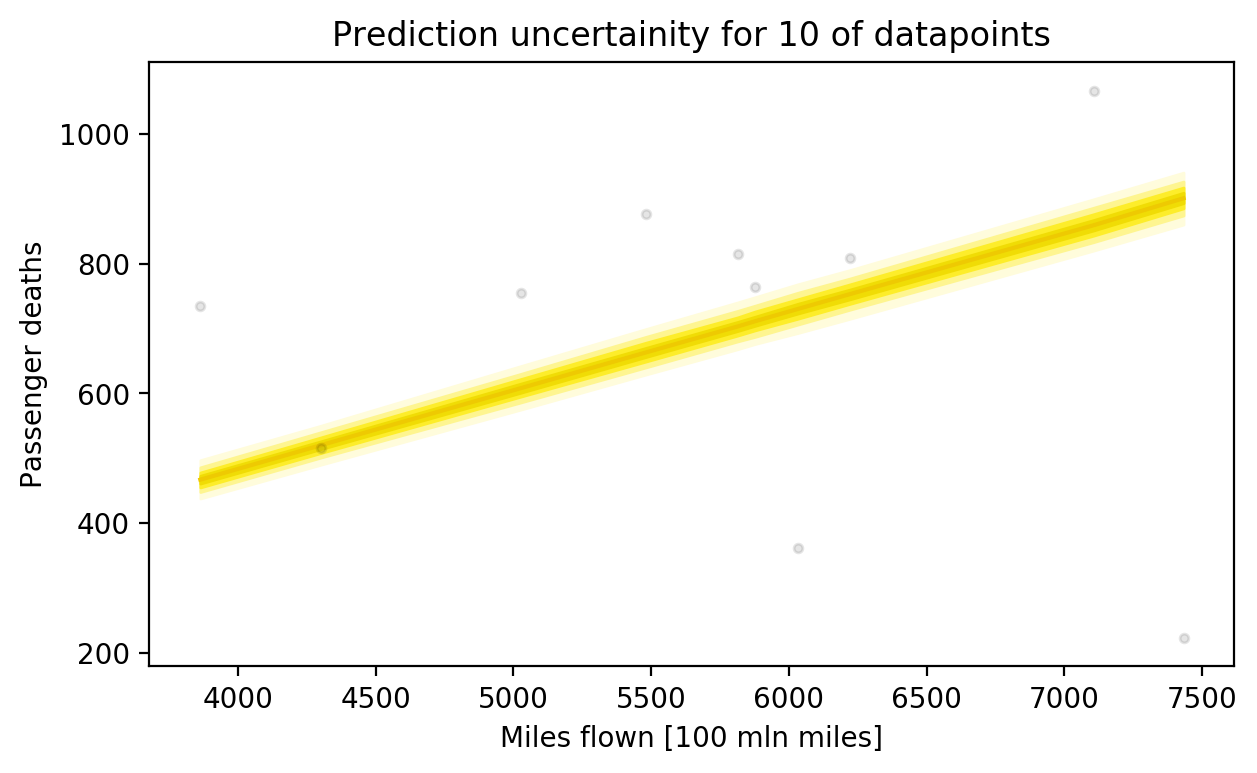

In [156]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(Airline_data['Miles flown [100 mln miles]'].values,params3_y,axes)
axes.scatter(Airline_data['Miles flown [100 mln miles]'],Airline_data['Passenger deaths'],color='black',alpha=0.1,s=10)
axes.set_ylabel('Passenger deaths')
axes.set_xlabel('Miles flown [100 mln miles]')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(Airline_data)))
plt.show()

# Summary

Our linear model does not fit datapoints very strictly. In fact it resembles kind of linear regression. Probably in case of bigger slope angle, prediction would be more proper. It would be useful to analyse the model one more time, however, in my opinion this example show us that linear model is not ideal for every situation.